(classifier)=
# Building a classifier

## The data set

This breast cancer databases was obtained from the University of Wisconsin Hospitals, Madison from Dr. William H. Wolberg. For more information see the documentation on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(original)).

In [6]:
library(dplyr)

In [56]:
biopsies <- read.csv("https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data",
         header = FALSE
        )

names(biopsies) <- c('ID','Clump.Thickness','Uniformity.of.Cell.Size','Uniformity.of.Cell.Shape','Marginal.Adhesion',
  'Single.Epithelial.Cell.Size','Bare.Nuclei','Bland.Chromatin','Normal.Nucleoli','Mitoses','Class')

biopsies <- biopsies %>%
    mutate(Class = factor( Class,
        levels = c(2,4),
        labels = c('benign', 'malignant')
    ))

### First look at the data

In [57]:
head(biopsies) 
str(biopsies)

,ID,Clump.Thickness,Uniformity.of.Cell.Size,Uniformity.of.Cell.Shape,Marginal.Adhesion,Single.Epithelial.Cell.Size,Bare.Nuclei,Bland.Chromatin,Normal.Nucleoli,Mitoses,Class
,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<int>,<int>,<int>,<fct>
1,1000025,5,1,1,1,2,1,3,1,1,benign
2,1002945,5,4,4,5,7,10,3,2,1,benign
3,1015425,3,1,1,1,2,2,3,1,1,benign
4,1016277,6,8,8,1,3,4,3,7,1,benign
5,1017023,4,1,1,3,2,1,3,1,1,benign
6,1017122,8,10,10,8,7,10,9,7,1,malignant


'data.frame':	699 obs. of  11 variables:
 $ ID                         : int  1000025 1002945 1015425 1016277 1017023 1017122 1018099 1018561 1033078 1033078 ...
 $ Clump.Thickness            : int  5 5 3 6 4 8 1 2 2 4 ...
 $ Uniformity.of.Cell.Size    : int  1 4 1 8 1 10 1 1 1 2 ...
 $ Uniformity.of.Cell.Shape   : int  1 4 1 8 1 10 1 2 1 1 ...
 $ Marginal.Adhesion          : int  1 5 1 1 3 8 1 1 1 1 ...
 $ Single.Epithelial.Cell.Size: int  2 7 2 3 2 7 2 2 2 2 ...
 $ Bare.Nuclei                : chr  "1" "10" "2" "4" ...
 $ Bland.Chromatin            : int  3 3 3 3 3 9 3 3 1 2 ...
 $ Normal.Nucleoli            : int  1 2 1 7 1 7 1 1 1 1 ...
 $ Mitoses                    : int  1 1 1 1 1 1 1 1 5 1 ...
 $ Class                      : Factor w/ 2 levels "benign","malignant": 1 1 1 1 1 2 1 1 1 1 ...


### Split the data

In [27]:
training <- head(biopsies, 400)
test <- head(biopsies, nrow(biopsies) - 400)

## Visualization

In practice, one looks at multiple pairs of variables before finding a pattern. For the sake of brevity, we only share the visualization that we will use for our classifier. 

In [12]:
library(ggplot2)

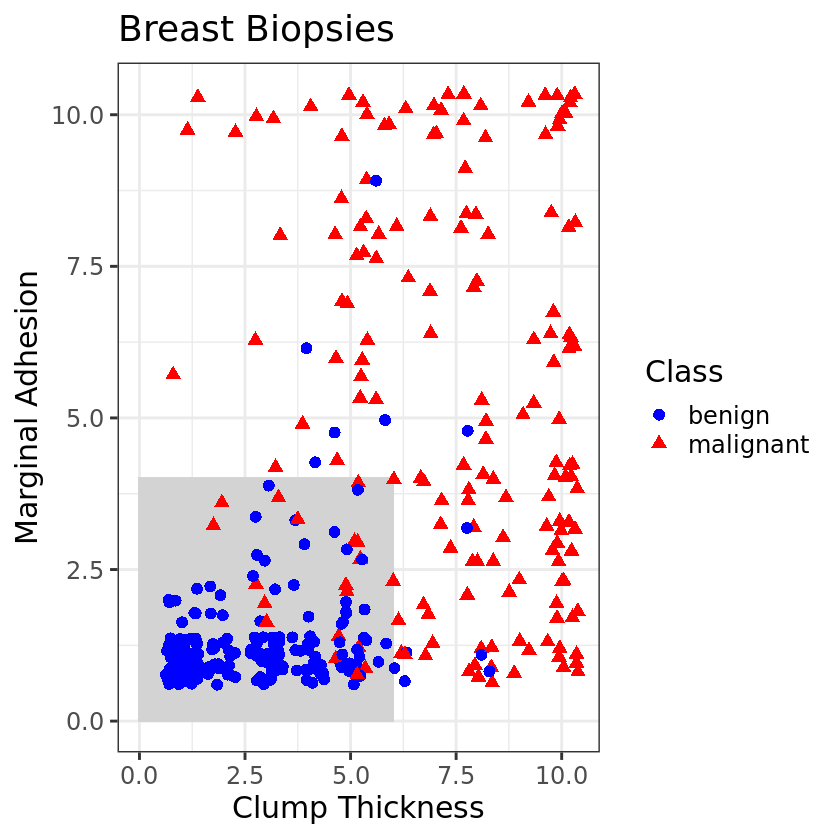

In [28]:
ggplot(training, aes(x = Clump.Thickness, y = Marginal.Adhesion, 
                     color = Class, shape = Class)
      ) + 
    geom_rect(mapping=aes(xmin=0, xmax=6, ymin=0, ymax=4),
              color = "lightgrey",
              fill = "lightgrey"
            )+
    geom_jitter(size=3) + 
    scale_color_manual(values =c('blue', 'red')) +
    labs(
        title = "Breast Biopsies",
        x = "Clump Thickness",
        y = "Marginal Adhesion"
    ) + 
    theme_bw(base_size = 18)

Points in the gray shaded rectangle are almost all benign. Thus, we will build a classifier that predicts lumps with clump thickness greater than 6 or marginal adhesion greater than 4 are malignant.

## Decision tree

Before coding the classifier function, it is helpful to draw a decision tree to ensure that the logic is clear. 

![decision tree](../img/decision_tree_small.png)

## Classifier function

### Build function

In [58]:
classifier <- function(thickness, adhesion){
    if(thickness > 6) {
        return('malignant')
    } else if (adhesion > 4) {
        return('malignant')
    } else {
        return('benign')
    }
}

# test classifer function
classifier(7,2)
classifier(3,5)
classifier(3,2)

# Vectorize so that we can apply it to whole columns
classifier <- Vectorize(classifier)

[1] "malignant"

[1] "malignant"

[1] "benign"

### Classify test observations

In [67]:
test <- mutate(test, 
              Prediction = classifier(Clump.Thickness, Marginal.Adhesion))

test %>%
    select(Clump.Thickness, Marginal.Adhesion, Class, Prediction) %>%
    head(4)

,Clump.Thickness,Marginal.Adhesion,Class,Prediction
,<int>,<int>,<fct>,<chr>
1,5,1,benign,benign
2,5,5,benign,malignant
3,3,1,benign,benign
4,6,1,benign,benign


## Evaluate classifier

### Accuracy type 

In [59]:
accuracy_type <- function(class, prediction){
    if (class == prediction){
        tf <- 'true'
    } else {
        tf <- 'false'
    }
    
    if(prediction == 'malignant') {
        pn <- 'positive'
    } else {
        pn <- 'negative'
    }
    
    paste(tf, pn) 
}

# Test accuracy_type function
accuracy_type('malignant','malignant')
accuracy_type('benign','malignant')
accuracy_type('malignant','benign')
accuracy_type('benign','benign')

# Vectorize so that we can apply it to whole columns
accuracy_type <- Vectorize(accuracy_type)

[1] "true positive"

[1] "false positive"

[1] "false negative"

[1] "true negative"

In [68]:
test <- mutate(test, type = accuracy_type(Class, Prediction))

test %>% 
    group_by(type) %>%
    summarize(Count = n())

type,Count
<chr>,<int>
false negative,23
false positive,7
true negative,156
true positive,113


### Measures of effectiveness

In [65]:
# variables to help make formulas easier to read
class <- test$Class
prediction <- test$Prediction
positive <- 'malignant'
negative <- 'benign'

#### Accuracy

$$\text{Accuracy} = \frac{\text{(# correct predictions)}}{\text{(# of observations)}}$$

In [50]:
sum(class == prediction) / nrow(test)

[1] 0.8996656

#### Precision

$$\text{Precision} = \frac{\text{(# true positive predictions)}}{\text{(# of positive predictions)}}$$

In [62]:
sum((class == prediction) & (prediction == positive))/sum(prediction == positive)

[1] 0.9416667

#### True positive rate

$$\text{True positive rate} = \frac{\text{(# true positive predictions)}}{\text{(# positive cases)}}$$

In [63]:
sum((class == prediction) & (prediction == positive))/sum(class == positive)

[1] 0.8308824

#### True negative rate

$$\text{True negative rate} = \frac{\text{(# true negative predictions)}}{\text{(# negative cases)}}$$

In [64]:
sum((class == prediction) & (prediction == negative))/sum(class == negative)

[1] 0.9570552

The classifier is correct 90% of the time. When it is incorrect, it is most likely to classify a malignant lump as benign. This is reflected in the fact that the number of false negatives is three times as high as the number of false positives. It is also reflected in the fact that the true positive rate is lower than the true negative rate; the classifier is more likely to correctly classify a benign lump. 